# Peek at Delta / Omicron Data

This notebook is quite computationally expensive, I run it on the Ermine node

### Outline

1. Reading in all Omicron/Delta data from bloom lab
2. Unpacking the data into a single functional scores dataframe
3. summarize coverage by experiment
4. filter out variants containing gapped alignments, and variants where the wildtype is supposedly a stop
5. Compute normalized functional scores and look at summary stats
6. TODO Explore barcodes and the variance between variant replicates within, and between experiments
    - pairplot of correlation between a few highly multiplexed variants?
    - maybe this would include all variants which have at least 
    - take the top ten and see where the replicates reside across all experiments
7. Output curated csv ready for fitting.

In [1]:
# TODO: How many barcodes per variant?
# TODO: How do the library barcodes compare?
# TODO: Outline the protocol?
# TODO: What's up with the *<n><aa> stop in aa_substitution_reference?

In [2]:
import os
import pickle
from itertools import combinations
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from timeit import default_timer as timer
from multidms.model import ϕ, g, prox, cost_smooth

### Globals

In [3]:
substitution_column = 'aa_substitutions_reference'
experiment_column = 'homolog_exp'
scaled_func_score_column = 'log2e'

### Define Fit Params

In [4]:
prep_params = {
    "fs_scaling_group_column" : "homolog_exp",
    "clip_y" : None,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1
}

## Read in metadata on homolog DMS experiments

In [5]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
    
# Show the dataframe summarizing all experiments
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


A single experiment functional scores df

In [6]:
func_score_data.loc[0, "func_sel_scores_df"]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions_reference,pre_count_threshold
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45126,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTCTATATCACCGCA,0.1505,8.3255,0,0,1187006,1069422,0.5,2,R78M A1013S,2,R78M A1015S,23
45127,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGAAAACCTCCTGT,0.1505,8.3255,0,0,1187006,1069422,0.5,0,NaN,0,NaN,23
45128,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGGCATAGGAGGCT,0.1505,8.3255,0,0,1187006,1069422,0.5,2,V169A,1,V171A,23
45129,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGTCAATCAGACTT,0.1505,8.3255,0,0,1187006,1069422,0.5,2,A67K T1115*,2,A67K T1117*,23


# All experiments combined

In [7]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df

  0%|          | 0/12 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions_reference,pre_count_threshold,homolog,replicate,homolog_exp
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1-1
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23,Delta,1,Delta-1-1
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23,Delta,1,Delta-1-1
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23,Delta,1,Delta-1-1
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23,Delta,1,Delta-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125122,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCCCTATTTAACG,-0.3878,8.3255,0,0,12769430,16707388,0.5,4,F65V Q132E N445T A698C,4,F65V Q134E N448T A701C,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125123,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCTCCATAACACC,-0.3878,8.3255,0,0,12769430,16707388,0.5,4,P26K D193N T382M D1160H,4,P26K D198N T385M D1163H,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125124,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCTTACCCCAATG,-0.3878,8.3255,0,0,12769430,16707388,0.5,1,L139P,1,L141P,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125125,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTTAAGAATAGATA,-0.3878,8.3255,0,0,12769430,16707388,0.5,1,D136Y,1,D138Y,70,Omicron_BA.1,1,Omicron_BA.1-3-1


In [8]:
func_score_df = func_score_df.sample(10000)

## Filter out variants

1. filters out the gapped alignment variants
2. filters out the variants that have a substitution that starts with "*" (e.g. *125T) also, wth??

In [9]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)

stop_wt_vars = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Summarize experiments by coverage

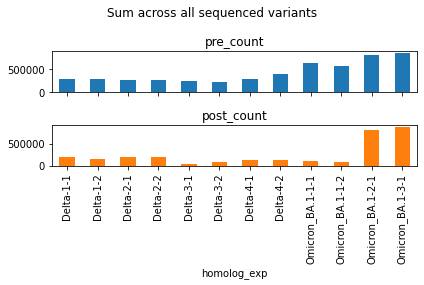

In [10]:
data = (func_score_df
    .groupby(["homolog_exp"])
    .sum()
    .reset_index()
#     .drop(["index"], axis=1)
).loc[:, ["pre_count", "post_count", "homolog_exp"]]
data.plot.bar(x="homolog_exp", subplots=True, legend=False)
plt.suptitle("Sum across all sequenced variants")
plt.tight_layout()
plt.show()

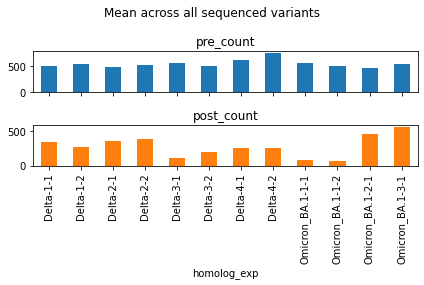

In [11]:
data = (func_score_df
    .groupby(["homolog_exp"])
    .mean()
    .reset_index()
#     .drop(["index"], axis=1)
).loc[:, ["pre_count", "post_count", "homolog_exp"]]
data.plot.bar(x="homolog_exp", subplots=True, legend=False)
plt.suptitle("Mean across all sequenced variants")
plt.tight_layout()
plt.show()

## Compute functional scores

In [12]:
dfs = []
for (h, hdf) in func_score_df.groupby(prep_params["fs_scaling_group_column"]):
    n_post_counts = sum(hdf['post_count'])
    if 'Delta' in h:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    else:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    hdf['orig_post_count'] = hdf['post_count']
    hdf['post_count'] *= scaling_factor
    hdf['post_count_wt'] *= scaling_factor
    print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

    # Recompute enrichment ratios with new counts
    hdf['pre_count_ps'] = hdf['pre_count'] + prep_params["pseudocount"]
    hdf['post_count_ps'] = hdf['post_count'] + prep_params["pseudocount"]
    hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + prep_params["pseudocount"]
    hdf['post_count_wt_ps'] = hdf['post_count_wt'] + prep_params["pseudocount"]

    total_pre_count = sum(hdf['pre_count_ps'])
    total_post_count = sum(hdf['post_count_ps'])

    hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
    hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
    hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
    hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

    hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
    hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
    hdf['e'] = hdf['var_e'] / hdf['wt_e']
    hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
    dfs.append(hdf)

func_score_df = pd.concat(dfs)

Delta-1-1 195742 0.51 100000.0
Delta-1-2 144170 0.69 100000.0
Delta-2-1 195126 0.51 100000.0
Delta-2-2 192008 0.52 100000.0
Delta-3-1 47758 2.09 100000.0
Delta-3-2 85322 1.17 100000.0
Delta-4-1 116880 0.86 100000.0
Delta-4-2 132156 0.76 100000.0
Omicron_BA.1-1-1 99115 1.01 100000.0
Omicron_BA.1-1-2 78739 1.27 100000.0
Omicron_BA.1-2-1 819124 0.12 100000.0
Omicron_BA.1-3-1 881205 0.11 100000.0


### Fit Model

In [37]:
fit_params = {
    "agg_variants" : True,
    "min_pre_counts" : 100,
    "func_score_target" : 'log2e',
    "experiment_ref" :'Delta-3-1',
    "experiment_2" : 'Omicron_BA.1-3-1',
    "shift_func_score_target_nonref" : -1,
    "warmup_to_ref" : False,
    "maxiter" : 5000,
    "λ_lasso" : 5e-5,
    "λ_ridge" : 0
}

In [38]:
if fit_params["experiment_2"]:
    print(f"{experiment_column}.isin(['{fit_params['experiment_ref']}', '{fit_params['experiment_2']}'])")
    func_score_df = func_score_df.query(
        f"{experiment_column}.isin(['{fit_params['experiment_ref']}', '{fit_params['experiment_2']}'])"
    )

homolog_exp.isin(['Delta-3-1', 'Omicron_BA.1-3-1'])


In [39]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
    func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
    func_score_df["post_count"] = func_score_df["post_count"].astype(int)

In [40]:
if fit_params["shift_func_score_target_nonref"]:
    h2_idx = func_score_df.query(f"{experiment_column} == '{fit_params['experiment_2']}'").index
    func_score_df.loc[h2_idx, fit_params["func_score_target"]] += fit_params["shift_func_score_target_nonref"]

In [41]:
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            fit_params["experiment_ref"],
                            substitution_column,
                            fit_params["func_score_target"]
                        )

Found 491 site(s) lacking data in at least one homolog.
769 of the 1658 variants were removed because they had mutations at the above sites, leaving 889 variants.


100%|██████████████████████████████████████████████████████| 622/622 [00:01<00:00, 319.56it/s]

There were 0 cache hits in total for homolog Omicron_BA.1-3-1.


In [42]:
sig_upper = df[fit_params["func_score_target"]].quantile(0.95)
sig_lower = df[fit_params["func_score_target"]].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[fit_params["experiment_ref"]].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [43]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=fit_params['λ_ridge']):.2e}")


Pre-Optimization
----------------
cost = 5.24e+00


In [44]:
tol = 1e-6
maxiter = fit_params['maxiter']
start = timer()

solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)

# First, just fit data on reference homolog
if fit_params["warmup_to_ref"]:
    print('Fitting model to just the reference homolog')
    params, state = solver.run(
        params, 
        hyperparams_prox = dict(
            lasso_params = None,
            lock_params = {
                f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
                f"S_{fit_params['experiment_2']}" : jnp.zeros(len(params['β'])),
                f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
                f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,))
            }
        ),
        data=(
            {fit_params['experiment_ref'] : X[fit_params['experiment_ref']]},
            {fit_params['experiment_ref'] : y[fit_params['experiment_ref']]}
        ),
        λ_ridge=0
    )

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params = {
            f"S_{fit_params['experiment_2']}" : fit_params['λ_lasso']
        },
        lock_params = {
            f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
            f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
            f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge']
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")

Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 5000 iterations
error = 1.65e-02
cost = 1.05e-01
Wall time for fit: 4.382322776000365


In [45]:
for param in ["β", f"S_{fit_params['experiment_ref']}", f"S_{fit_params['experiment_2']}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")
    
# if f"C_{fit_params['experiment_2']}" in params:
#     print(f"\nC_{fit_params['experiment_2']}: {params[f"C_{fit_params['experiment_2']}]}"

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{fit_params['func_score_target']}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(experiment_column):
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{fit_params['func_score_target']}"] = y_h_pred

print(f"Done")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -4.37e-01
Median = -1.69e-01
Measures of Dispersion
Minimum = -1.61e+01
Maximum = 1.22e+01
Range = 2.83e+01
Variance = 5.20e+00
Standard Deviation = 2.28e+00

Fit S_Delta-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 1.27e-02
Median = 0.00e+00
Measures of Dispersion
Minimum = -4.24e+00
Maximum = 6.50e+00
Range = 1.07e+01
Variance = 2.58e-01
Standard Deviation = 5.08e-01

Fit Sigmoid Parameters, α
ge_bias: [-10.3113476]
ge_scale: [11.00456302]
latent_bias: [2.24301102]

Running Predictions
-------------------
Done


In [46]:
# all_subs.copy()

In [47]:
df

,index,aa_substitutions_reference,homolog_exp,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,...,pre_freq_wt,post_freq_wt,wt_e,var_e,e,log2e,allowed_variant,var_wrt_ref,predicted_latent_phenotype,predicted_log2e
0,0,,Delta-3-1,-0.189133,0.031989,613,412,1154203.0,7.496440e+05,0.5,...,4.644871,7.493084,1.613195,1.797890,1.114490,-0.195715,True,,0.000000,-0.362717
1,1,,Omicron_BA.1-3-1,-0.165438,0.140148,676,101,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,1.377285,1.081737,-2.121703,True,D796Y R681H L981F A67V E484A N950D S477N Y505H...,-1.210938,-2.197490
3,3,A1020G,Delta-3-1,0.165950,0.009950,1857,1270,1154203.0,7.496440e+05,0.5,...,4.644871,7.493084,1.613195,1.814067,1.124518,0.164375,True,A1020G,0.514327,0.036534
4,4,A1020L,Omicron_BA.1-3-1,-3.969500,0.121900,221,2,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.083101,0.065269,-5.937468,True,A1020L D796Y R681H L981F A67V E484A N950D S477...,-2.667045,-5.958472
5,5,A1022V,Omicron_BA.1-3-1,-3.853000,0.100900,248,2,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.089746,0.070488,-5.826479,True,D796Y R681H L981F A67V E484A N950D S477N Y505H...,-2.627267,-5.853391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,1649,Y489H V1068A,Omicron_BA.1-3-1,-6.175000,0.470900,248,0,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.019145,0.015037,-8.055333,True,D796Y R681H L981F A67V E484A N950D V1068A S477...,-3.617103,-8.088871
1650,1650,Y495H,Omicron_BA.1-3-1,-2.465500,0.039300,276,7,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.232199,0.182372,-4.455044,True,D796Y R681H L981F A67V E484A N950D S477N Y505H...,-2.117051,-4.462991
1654,1654,Y655P,Omicron_BA.1-3-1,-2.485400,0.205400,53,1,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.236062,0.185406,-4.431236,True,D796Y R681H L981F A67V E484A N950D S477N Y505H...,-2.064128,-4.318243
1656,1656,Y655R A845S K1191G,Omicron_BA.1-3-1,-0.722200,0.324500,14,1,12769430.0,1.895971e+06,0.5,...,14.867868,18.930006,1.273216,0.819986,0.644027,-2.634806,True,D796Y R681H L981F A67V K1191G E484A A845S N950...,-1.485087,-2.818308


In [48]:
row = prep_params.copy()
row.update(fit_params)
row["tuned_model_params_dict"] = params.copy()
row["all_subs_list"] = all_subs.copy()
row["variant_prediction_df"] = df.drop("index", axis=1)
results = pd.DataFrame(columns = list(row.keys()))
# results = pickle.load(open("results.pkl", "rb"))
results.loc[len(results)] = pd.Series(row)
results

,fs_scaling_group_column,clip_y,min_pre_counts,pseudocount,agg_variants,func_score_target,experiment_ref,experiment_2,shift_func_score_target_nonref,warmup_to_ref,maxiter,λ_lasso,λ_ridge,tuned_model_params_dict,all_subs_list,variant_prediction_df
0,homolog_exp,None,100,0.1,True,log2e,Delta-3-1,Omicron_BA.1-3-1,-1,False,5000,0.00005,0,"{'C_Delta-3-1': [0.0], 'C_Omicron_BA.1-3-1': [...","[F4I, F4L, L5A, L5G, L5N, L5P, L5R, L5T, P9R, ...",aa_substitutions_reference homolog_...


In [50]:
# results.loc[0, "variant_prediction_df"]

In [49]:
pickle.dump(results, open("results.pkl", "wb"))

In [62]:
func_score_data[experiment_column]

0            Delta-1-1
1            Delta-1-2
2            Delta-3-1
3            Delta-3-2
4            Delta-4-1
5            Delta-4-2
6            Delta-2-1
7            Delta-2-2
8     Omicron_BA.1-1-1
9     Omicron_BA.1-1-2
10    Omicron_BA.1-2-1
11    Omicron_BA.1-3-1
Name: homolog_exp, dtype: object

In [ ]:
#for omic_exp in func_score_data.query()
# omicron_exp = [row[''] for ]

In [66]:
# from itertools import combinations
# for i, comb in enumerate(combinations(func_score_data[experiment_column].values, 2)):
#     print(comb)

('Delta-1-1', 'Delta-1-2')
('Delta-1-1', 'Delta-3-1')
('Delta-1-1', 'Delta-3-2')
('Delta-1-1', 'Delta-4-1')
('Delta-1-1', 'Delta-4-2')
('Delta-1-1', 'Delta-2-1')
('Delta-1-1', 'Delta-2-2')
('Delta-1-1', 'Omicron_BA.1-1-1')
('Delta-1-1', 'Omicron_BA.1-1-2')
('Delta-1-1', 'Omicron_BA.1-2-1')
('Delta-1-1', 'Omicron_BA.1-3-1')
('Delta-1-2', 'Delta-3-1')
('Delta-1-2', 'Delta-3-2')
('Delta-1-2', 'Delta-4-1')
('Delta-1-2', 'Delta-4-2')
('Delta-1-2', 'Delta-2-1')
('Delta-1-2', 'Delta-2-2')
('Delta-1-2', 'Omicron_BA.1-1-1')
('Delta-1-2', 'Omicron_BA.1-1-2')
('Delta-1-2', 'Omicron_BA.1-2-1')
('Delta-1-2', 'Omicron_BA.1-3-1')
('Delta-3-1', 'Delta-3-2')
('Delta-3-1', 'Delta-4-1')
('Delta-3-1', 'Delta-4-2')
('Delta-3-1', 'Delta-2-1')
('Delta-3-1', 'Delta-2-2')
('Delta-3-1', 'Omicron_BA.1-1-1')
('Delta-3-1', 'Omicron_BA.1-1-2')
('Delta-3-1', 'Omicron_BA.1-2-1')
('Delta-3-1', 'Omicron_BA.1-3-1')
('Delta-3-2', 'Delta-4-1')
('Delta-3-2', 'Delta-4-2')
('Delta-3-2', 'Delta-2-1')
('Delta-3-2', 'Delta-2-2'

In [67]:
i

65